In [2]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import os
from itertools import cycle

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import RobustScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical

import optuna

c:\Users\shoha\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
pwd = os.getcwd()
pwd

'd:\\Research Projects\\HEA\\Featurize_New_Alloys\\HEA'

In [4]:
df = pd.read_csv(pwd+"/raw_dataset/HEA_tr_NETCORE.csv")
print("Shape of Dataframe: ", df.shape)
df.head()

Shape of Dataframe:  (1167, 44)


,Alloy,avg_dev_AtomicWeight,maximum_MeltingT,avg_dev_MeltingT,mode_MeltingT,avg_dev_Column,mean_Row,mode_Row,minimum_CovalentRadius,maximum_CovalentRadius,range_CovalentRadius,avg_dev_CovalentRadius,mode_CovalentRadius,maximum_Electronegativity,mean_Electronegativity,mode_Electronegativity,mean_NsValence,maximum_NpValence,mean_NpValence,avg_dev_NpValence,range_NdValence,mean_NdValence,avg_dev_NdValence,avg_dev_NValence,mode_NValence,maximum_NdUnfilled,range_NdUnfilled,avg_dev_NdUnfilled,mode_NUnfilled,minimum_GSvolume_pa,range_GSvolume_pa,mode_GSvolume_pa,maximum_GSbandgap,avg_dev_GSbandgap,range_GSmagmom,minimum_SpaceGroupNumber,maximum_SpaceGroupNumber,mean_SpaceGroupNumber,range_Column,maximum_NpUnfilled,maximum_NdValence,mode_MendeleevNumber,range_NUnfilled,Phase
0,Al0.5NbTaTiV,3.838070,3290.0,584.546173,7.571474,0.966843,4.555556,4,121,170,3.912023,2.391138,153,1.63,1.572222,0.916291,1.777778,0.693147,0.111111,0.180262,4,2.666667,0.635989,1.797913,1.609438,8,8,0.908856,7,2.639771,1.819699,2.639771,0.0,0.0,0.000023,194,229,220.777778,9,5,4,43,3,BCC
1,Al0.75MoNbTiV,3.255577,2896.0,521.067701,7.571474,1.140210,4.263158,4,121,164,3.784190,2.377029,153,2.16,1.713158,0.932164,1.578947,0.693147,0.157895,0.235805,5,2.947368,0.845714,0.598806,1.609438,8,8,1.074312,6,2.639771,1.819699,2.639771,0.0,0.0,0.000023,194,229,221.000000,9,5,5,43,3,BCC
2,Al0.25MoNbTiV,3.205911,2896.0,441.662561,7.571474,0.758442,4.411765,4,121,164,3.784190,1.950841,153,2.16,1.725294,0.932164,1.529412,0.693147,0.058824,0.105014,5,3.294118,0.758442,0.492669,1.609438,8,8,0.833360,6,2.639771,1.819699,2.639771,0.0,0.0,0.000023,194,229,220.529412,9,5,5,43,3,BCC
3,Al0.25NbTaTiV,3.825406,3290.0,539.821730,7.571474,0.648931,4.647059,4,121,170,3.912023,2.140270,153,1.63,1.570000,0.916291,1.764706,0.693147,0.058824,0.105014,4,2.823529,0.542163,1.825219,1.609438,8,8,0.718768,7,2.639771,1.819699,2.639771,0.0,0.0,0.000023,194,229,220.529412,9,5,4,43,3,BCC
4,Al0.2MoTaTiV,3.838178,3290.0,565.511565,7.571474,0.703300,4.666667,4,121,170,3.912023,2.105461,153,2.16,1.702857,0.916291,1.761905,0.693147,0.047619,0.086822,5,3.095238,0.645547,1.812332,1.609438,8,8,0.829650,6,2.639771,1.809927,2.639771,0.0,0.0,0.000023,194,229,220.476191,9,5,5,43,3,BCC


In [5]:
# SHUFFLE THE DATASET
df = df.sample(frac=1, random_state=42)
X = df.copy().drop(columns=["Alloy", "Phase"])
y = df["Phase"].astype("category")
print(f"Shape of feature: {X.shape}\nShape of labels: {y.shape}")

Shape of feature: (1167, 42)
Shape of labels: (1167,)


In [6]:
# check class imbalance
print(y.value_counts(ascending=False))

Phase
MIP        428
BCC        363
FCC        211
FCC_BCC    165
Name: count, dtype: int64


In [7]:
from imblearn.over_sampling import SMOTE
X, y = SMOTE(random_state=42).fit_resample(X, y)
print(f"Shape of feature: {X.shape}\nShape of labels: {y.shape}")

Shape of feature: (1712, 42)
Shape of labels: (1712,)


c:\Users\shoha\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\shoha\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [8]:
# check for class imbalance
print(y.value_counts(ascending=False))

Phase
BCC        428
FCC        428
FCC_BCC    428
MIP        428
Name: count, dtype: int64


In [9]:
# SCALE FEATURES
X = pd.DataFrame(RobustScaler().fit_transform(X), columns=X.columns)
X.head()

,avg_dev_AtomicWeight,maximum_MeltingT,avg_dev_MeltingT,mode_MeltingT,avg_dev_Column,mean_Row,mode_Row,minimum_CovalentRadius,maximum_CovalentRadius,range_CovalentRadius,avg_dev_CovalentRadius,mode_CovalentRadius,maximum_Electronegativity,mean_Electronegativity,mode_Electronegativity,mean_NsValence,maximum_NpValence,mean_NpValence,avg_dev_NpValence,range_NdValence,mean_NdValence,avg_dev_NdValence,avg_dev_NValence,mode_NValence,maximum_NdUnfilled,range_NdUnfilled,avg_dev_NdUnfilled,mode_NUnfilled,minimum_GSvolume_pa,range_GSvolume_pa,mode_GSvolume_pa,maximum_GSbandgap,avg_dev_GSbandgap,range_GSmagmom,minimum_SpaceGroupNumber,maximum_SpaceGroupNumber,mean_SpaceGroupNumber,range_Column,maximum_NpUnfilled,maximum_NdValence,mode_MendeleevNumber,range_NUnfilled
0,0.161097,1.256140,0.606754,0.532601,0.521256,-0.216360,0.0,0.0,0.18,0.584759,0.717467,1.363636,0.25,0.232362,0.449317,-1.196825,0.000000,0.477222,0.422557,0.000000,-0.304043,0.175303,-0.008391,0.000000,0.000000,0.0,0.190333,1.333333,0.000000,0.000000,0.336801,0.000,0.000000,0.0,0.0,0.0,0.640823,0.000000,0.0,0.0,0.000000,0.0
1,-0.709468,-0.647368,-0.538152,-0.471801,-0.863198,0.220453,0.0,1.0,-0.42,-0.427776,-1.279471,0.000000,0.05,1.471545,1.916202,-0.110975,0.584963,-0.223215,-0.254527,-0.666667,1.487024,-0.236945,-0.963679,0.560099,-0.333333,-0.5,-0.196263,-0.333333,0.000000,10.948033,-0.030237,0.000,0.000000,0.0,-53.0,0.0,-0.640578,-0.333333,-0.2,1.0,0.666667,-1.0
2,-0.551801,-0.647368,-0.934202,0.039657,-0.977210,-0.216360,0.0,0.0,-0.70,-0.814217,-1.599888,0.000000,0.00,1.090976,1.916202,1.809577,0.000000,0.026149,0.020301,0.000000,0.584874,-0.225051,-0.802636,0.560099,-0.333333,-0.5,-0.853525,0.000000,0.000000,0.000000,-0.030237,0.000,0.000000,0.0,0.0,0.0,-0.694305,-0.666667,0.0,0.0,0.666667,-1.0
3,0.428073,2.882456,0.969928,-1.266392,0.594814,-1.406341,-1.0,-15.0,-0.42,1.434420,1.058207,-0.272727,0.64,0.850365,0.000000,0.362050,0.584963,1.529725,1.115875,0.000000,-0.534503,0.775456,0.299071,-1.247204,0.000000,0.0,0.262099,0.000000,-79.249736,4.490789,-0.030237,4.496,0.616735,0.0,0.0,0.0,-0.283342,0.333333,0.0,0.0,0.000000,0.0
4,0.071655,1.256140,0.363886,0.039657,0.103571,0.140634,0.0,0.0,0.18,0.584759,0.646848,0.000000,0.25,0.820978,0.449317,-0.535416,0.000000,0.161471,0.153797,0.000000,0.067211,0.047385,-0.120768,0.000000,0.000000,0.0,-0.141745,0.000000,0.000000,0.000000,-0.030237,0.000,0.000000,0.0,0.0,0.0,0.269152,0.000000,0.0,0.0,0.000000,0.0


In [10]:
# Label encode y and then to_categorical
lb_enc = LabelEncoder()
y = lb_enc.fit_transform(y)

In [11]:
labels = list(lb_enc.classes_)
labels

['BCC', 'FCC', 'FCC_BCC', 'MIP']

In [12]:
print(dict(zip(lb_enc.inverse_transform([0, 1, 2, 3]), [0, 1, 2, 3])))

{'BCC': 0, 'FCC': 1, 'FCC_BCC': 2, 'MIP': 3}


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Shape of training features: {X_train.shape}")
print(f"Shape of training labels: {y_train.shape}")
print(f"Shape of test features: {X_test.shape}")
print(f"Shape of test labels: {y_test.shape}")

Shape of training features: (1369, 42)
Shape of training labels: (1369,)
Shape of test features: (343, 42)
Shape of test labels: (343,)


In [14]:
# DEFINE OBJECTIVE FUNCTION
def obj_fn(trial):
    # DEFINE PARAMETER SPACE
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500, step=50),
        "max_depth":    trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "criterion": trial.suggest_categorical("criterion", ['friedman_mse', 'squared_error']),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
    }
    # CONSTRUCT MODEL
    model = GradientBoostingClassifier(**params, random_state=42)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)

    return test_acc

In [15]:
# PERFORM BAYESIAN OPTIMIZATION
tpe = optuna.samplers.TPESampler()
study = optuna.create_study(direction="maximize", sampler=tpe)
study.optimize(obj_fn, n_trials=50, show_progress_bar=True)

[I 2024-10-01 04:18:09,837] A new study created in memory with name: no-name-f1baf4d6-20b7-46a8-a9a2-98287697e2b7
Best trial: 0. Best value: 0.857143:   2%|▏         | 1/50 [00:17<14:11, 17.38s/it]

[I 2024-10-01 04:18:27,213] Trial 0 finished with value: 0.8571428571428571 and parameters: {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.021154776535910896, 'subsample': 0.683674523083817, 'criterion': 'friedman_mse', 'min_samples_split': 12, 'min_samples_leaf': 11}. Best is trial 0 with value: 0.8571428571428571.


Best trial: 0. Best value: 0.857143:   4%|▍         | 2/50 [00:21<07:31,  9.40s/it]

[I 2024-10-01 04:18:31,025] Trial 1 finished with value: 0.8425655976676385 and parameters: {'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.1516073395826587, 'subsample': 0.8576997381154765, 'criterion': 'squared_error', 'min_samples_split': 15, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8571428571428571.


Best trial: 2. Best value: 0.862974:   6%|▌         | 3/50 [00:27<06:15,  7.98s/it]

[I 2024-10-01 04:18:37,325] Trial 2 finished with value: 0.8629737609329446 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.11309187806675676, 'subsample': 0.8097960151526518, 'criterion': 'squared_error', 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.8629737609329446.


Best trial: 2. Best value: 0.862974:   8%|▊         | 4/50 [00:42<08:11, 10.68s/it]

[I 2024-10-01 04:18:52,148] Trial 3 finished with value: 0.8629737609329446 and parameters: {'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.018479310807416518, 'subsample': 0.8143831562814672, 'criterion': 'friedman_mse', 'min_samples_split': 12, 'min_samples_leaf': 12}. Best is trial 2 with value: 0.8629737609329446.


Best trial: 4. Best value: 0.865889:  10%|█         | 5/50 [00:51<07:33, 10.08s/it]

[I 2024-10-01 04:19:01,173] Trial 4 finished with value: 0.8658892128279884 and parameters: {'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.010679367714532066, 'subsample': 0.8518824502771531, 'criterion': 'friedman_mse', 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 4 with value: 0.8658892128279884.


Best trial: 5. Best value: 0.868805:  12%|█▏        | 6/50 [01:10<09:45, 13.30s/it]

[I 2024-10-01 04:19:20,703] Trial 5 finished with value: 0.8688046647230321 and parameters: {'n_estimators': 350, 'max_depth': 7, 'learning_rate': 0.064193767638887, 'subsample': 0.9990049267735752, 'criterion': 'squared_error', 'min_samples_split': 9, 'min_samples_leaf': 19}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  14%|█▍        | 7/50 [01:24<09:32, 13.32s/it]

[I 2024-10-01 04:19:34,077] Trial 6 finished with value: 0.8629737609329446 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.11999267798616517, 'subsample': 0.9046566104027388, 'criterion': 'friedman_mse', 'min_samples_split': 18, 'min_samples_leaf': 18}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  16%|█▌        | 8/50 [01:58<13:53, 19.84s/it]

[I 2024-10-01 04:20:07,874] Trial 7 finished with value: 0.8279883381924198 and parameters: {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.12963177634313935, 'subsample': 0.9276014036410851, 'criterion': 'friedman_mse', 'min_samples_split': 12, 'min_samples_leaf': 2}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  18%|█▊        | 9/50 [02:03<10:34, 15.47s/it]

[I 2024-10-01 04:20:13,742] Trial 8 finished with value: 0.8542274052478134 and parameters: {'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.025878254889130207, 'subsample': 0.5373114807440917, 'criterion': 'friedman_mse', 'min_samples_split': 4, 'min_samples_leaf': 12}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  20%|██        | 10/50 [02:07<07:46, 11.67s/it]

[I 2024-10-01 04:20:16,914] Trial 9 finished with value: 0.8425655976676385 and parameters: {'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.21438072957696794, 'subsample': 0.9814963514039137, 'criterion': 'squared_error', 'min_samples_split': 18, 'min_samples_leaf': 9}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  22%|██▏       | 11/50 [02:14<06:46, 10.43s/it]

[I 2024-10-01 04:20:24,528] Trial 10 finished with value: 0.8513119533527697 and parameters: {'n_estimators': 350, 'max_depth': 3, 'learning_rate': 0.05453580214826832, 'subsample': 0.6966079543167699, 'criterion': 'squared_error', 'min_samples_split': 8, 'min_samples_leaf': 20}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  24%|██▍       | 12/50 [02:31<07:51, 12.41s/it]

[I 2024-10-01 04:20:41,467] Trial 11 finished with value: 0.8425655976676385 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.011128458039173415, 'subsample': 0.9962014404468341, 'criterion': 'squared_error', 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  26%|██▌       | 13/50 [02:39<06:46, 10.98s/it]

[I 2024-10-01 04:20:49,148] Trial 12 finished with value: 0.8571428571428571 and parameters: {'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.0518515159627032, 'subsample': 0.7598928824361455, 'criterion': 'squared_error', 'min_samples_split': 8, 'min_samples_leaf': 16}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  28%|██▊       | 14/50 [02:52<06:59, 11.67s/it]

[I 2024-10-01 04:21:02,401] Trial 13 finished with value: 0.8513119533527697 and parameters: {'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.03738858783253981, 'subsample': 0.9019801384106929, 'criterion': 'friedman_mse', 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  30%|███       | 15/50 [03:51<15:10, 26.01s/it]

[I 2024-10-01 04:22:01,637] Trial 14 finished with value: 0.8658892128279884 and parameters: {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.010541112617398575, 'subsample': 0.5634260332793042, 'criterion': 'friedman_mse', 'min_samples_split': 9, 'min_samples_leaf': 15}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  32%|███▏      | 16/50 [05:20<25:29, 44.99s/it]

[I 2024-10-01 04:23:30,700] Trial 15 finished with value: 0.8629737609329446 and parameters: {'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.07371735809512285, 'subsample': 0.950384460958198, 'criterion': 'squared_error', 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  34%|███▍      | 17/50 [05:31<19:04, 34.69s/it]

[I 2024-10-01 04:23:41,448] Trial 16 finished with value: 0.8542274052478134 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.07606015029574069, 'subsample': 0.6316026645590546, 'criterion': 'squared_error', 'min_samples_split': 15, 'min_samples_leaf': 14}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  36%|███▌      | 18/50 [06:46<24:54, 46.71s/it]

[I 2024-10-01 04:24:56,133] Trial 17 finished with value: 0.8367346938775511 and parameters: {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.2874791054443251, 'subsample': 0.8405682260558309, 'criterion': 'friedman_mse', 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  38%|███▊      | 19/50 [07:28<23:24, 45.32s/it]

[I 2024-10-01 04:25:38,193] Trial 18 finished with value: 0.8629737609329446 and parameters: {'n_estimators': 250, 'max_depth': 9, 'learning_rate': 0.015281482574284454, 'subsample': 0.7662880929396201, 'criterion': 'friedman_mse', 'min_samples_split': 15, 'min_samples_leaf': 20}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  40%|████      | 20/50 [08:17<23:09, 46.32s/it]

[I 2024-10-01 04:26:26,856] Trial 19 finished with value: 0.8600583090379009 and parameters: {'n_estimators': 350, 'max_depth': 5, 'learning_rate': 0.03282707723176147, 'subsample': 0.8814530088246446, 'criterion': 'squared_error', 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  42%|████▏     | 21/50 [08:41<19:12, 39.73s/it]

[I 2024-10-01 04:26:51,221] Trial 20 finished with value: 0.8542274052478134 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.04060811003368309, 'subsample': 0.9490610582883482, 'criterion': 'squared_error', 'min_samples_split': 3, 'min_samples_leaf': 17}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  44%|████▍     | 22/50 [09:41<21:22, 45.80s/it]

[I 2024-10-01 04:27:51,168] Trial 21 finished with value: 0.8600583090379009 and parameters: {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.012533080070890741, 'subsample': 0.5210406648696666, 'criterion': 'friedman_mse', 'min_samples_split': 10, 'min_samples_leaf': 15}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  46%|████▌     | 23/50 [10:48<23:30, 52.26s/it]

[I 2024-10-01 04:28:58,490] Trial 22 finished with value: 0.8600583090379009 and parameters: {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.010460020574841727, 'subsample': 0.5965098774785, 'criterion': 'friedman_mse', 'min_samples_split': 7, 'min_samples_leaf': 14}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  48%|████▊     | 24/50 [11:50<23:55, 55.23s/it]

[I 2024-10-01 04:30:00,646] Trial 23 finished with value: 0.8571428571428571 and parameters: {'n_estimators': 450, 'max_depth': 7, 'learning_rate': 0.01524730017892299, 'subsample': 0.7042537834963414, 'criterion': 'friedman_mse', 'min_samples_split': 9, 'min_samples_leaf': 18}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  50%|█████     | 25/50 [12:34<21:37, 51.90s/it]

[I 2024-10-01 04:30:44,780] Trial 24 finished with value: 0.8629737609329446 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.02512396617465002, 'subsample': 0.568606205733157, 'criterion': 'friedman_mse', 'min_samples_split': 11, 'min_samples_leaf': 19}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  52%|█████▏    | 26/50 [13:46<23:07, 57.83s/it]

[I 2024-10-01 04:31:56,443] Trial 25 finished with value: 0.8542274052478134 and parameters: {'n_estimators': 450, 'max_depth': 8, 'learning_rate': 0.0732803195064044, 'subsample': 0.6608512465206471, 'criterion': 'friedman_mse', 'min_samples_split': 13, 'min_samples_leaf': 10}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  54%|█████▍    | 27/50 [14:57<23:42, 61.85s/it]

[I 2024-10-01 04:33:07,695] Trial 26 finished with value: 0.8600583090379009 and parameters: {'n_estimators': 450, 'max_depth': 7, 'learning_rate': 0.015063951105008735, 'subsample': 0.7376545295275032, 'criterion': 'friedman_mse', 'min_samples_split': 6, 'min_samples_leaf': 13}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  56%|█████▌    | 28/50 [15:35<19:58, 54.47s/it]

[I 2024-10-01 04:33:44,921] Trial 27 finished with value: 0.8688046647230321 and parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.028806336970556505, 'subsample': 0.7894110238339773, 'criterion': 'friedman_mse', 'min_samples_split': 10, 'min_samples_leaf': 16}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  58%|█████▊    | 29/50 [16:20<18:03, 51.61s/it]

[I 2024-10-01 04:34:29,869] Trial 28 finished with value: 0.8571428571428571 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.031054570706371503, 'subsample': 0.8000939156600178, 'criterion': 'squared_error', 'min_samples_split': 20, 'min_samples_leaf': 7}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  60%|██████    | 30/50 [16:40<14:08, 42.41s/it]

[I 2024-10-01 04:34:50,829] Trial 29 finished with value: 0.8600583090379009 and parameters: {'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.021342924962801463, 'subsample': 0.8541639251671519, 'criterion': 'friedman_mse', 'min_samples_split': 14, 'min_samples_leaf': 11}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  62%|██████▏   | 31/50 [17:16<12:46, 40.36s/it]

[I 2024-10-01 04:35:26,397] Trial 30 finished with value: 0.8483965014577259 and parameters: {'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.09147633750105319, 'subsample': 0.7343676001760422, 'criterion': 'friedman_mse', 'min_samples_split': 11, 'min_samples_leaf': 17}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  64%|██████▍   | 32/50 [17:30<09:44, 32.48s/it]

[I 2024-10-01 04:35:40,501] Trial 31 finished with value: 0.8600583090379009 and parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.04533899321487101, 'subsample': 0.6313121925123917, 'criterion': 'friedman_mse', 'min_samples_split': 9, 'min_samples_leaf': 16}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  66%|██████▌   | 33/50 [18:07<09:33, 33.76s/it]

[I 2024-10-01 04:36:17,238] Trial 32 finished with value: 0.8571428571428571 and parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.019235905179920722, 'subsample': 0.7803499895537144, 'criterion': 'friedman_mse', 'min_samples_split': 10, 'min_samples_leaf': 15}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  68%|██████▊   | 34/50 [19:05<10:58, 41.16s/it]

[I 2024-10-01 04:37:15,676] Trial 33 finished with value: 0.8658892128279884 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.012956712741423205, 'subsample': 0.8285700316152729, 'criterion': 'friedman_mse', 'min_samples_split': 7, 'min_samples_leaf': 18}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  70%|███████   | 35/50 [19:22<08:28, 33.87s/it]

[I 2024-10-01 04:37:32,543] Trial 34 finished with value: 0.8571428571428571 and parameters: {'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.022884514129917218, 'subsample': 0.5000662079353058, 'criterion': 'friedman_mse', 'min_samples_split': 9, 'min_samples_leaf': 16}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  72%|███████▏  | 36/50 [20:27<10:02, 43.06s/it]

[I 2024-10-01 04:38:37,050] Trial 35 finished with value: 0.8658892128279884 and parameters: {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.010395512547936372, 'subsample': 0.874222235833186, 'criterion': 'friedman_mse', 'min_samples_split': 7, 'min_samples_leaf': 19}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  74%|███████▍  | 37/50 [21:11<09:24, 43.41s/it]

[I 2024-10-01 04:39:21,271] Trial 36 finished with value: 0.8571428571428571 and parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.016742059306157516, 'subsample': 0.7848737819695197, 'criterion': 'squared_error', 'min_samples_split': 13, 'min_samples_leaf': 3}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  76%|███████▌  | 38/50 [21:20<06:36, 33.04s/it]

[I 2024-10-01 04:39:30,123] Trial 37 finished with value: 0.8425655976676385 and parameters: {'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.028793016903474262, 'subsample': 0.9673040679052505, 'criterion': 'friedman_mse', 'min_samples_split': 12, 'min_samples_leaf': 12}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  78%|███████▊  | 39/50 [22:01<06:29, 35.39s/it]

[I 2024-10-01 04:40:11,001] Trial 38 finished with value: 0.8600583090379009 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.012841267484564073, 'subsample': 0.9191359772756572, 'criterion': 'friedman_mse', 'min_samples_split': 10, 'min_samples_leaf': 13}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  80%|████████  | 40/50 [22:51<06:39, 39.93s/it]

[I 2024-10-01 04:41:01,508] Trial 39 finished with value: 0.8600583090379009 and parameters: {'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.1456235540148179, 'subsample': 0.7184407278596647, 'criterion': 'squared_error', 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  82%|████████▏ | 41/50 [23:44<06:33, 43.71s/it]

[I 2024-10-01 04:41:54,065] Trial 40 finished with value: 0.8454810495626822 and parameters: {'n_estimators': 350, 'max_depth': 7, 'learning_rate': 0.0987624828411357, 'subsample': 0.6605129700434386, 'criterion': 'friedman_mse', 'min_samples_split': 11, 'min_samples_leaf': 19}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  84%|████████▍ | 42/50 [24:46<06:33, 49.22s/it]

[I 2024-10-01 04:42:56,124] Trial 41 finished with value: 0.8629737609329446 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.013246927747332967, 'subsample': 0.8340873485397698, 'criterion': 'friedman_mse', 'min_samples_split': 7, 'min_samples_leaf': 18}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  86%|████████▌ | 43/50 [25:44<06:02, 51.77s/it]

[I 2024-10-01 04:43:53,864] Trial 42 finished with value: 0.8629737609329446 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.012334448985303644, 'subsample': 0.8124061160498262, 'criterion': 'friedman_mse', 'min_samples_split': 6, 'min_samples_leaf': 17}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  88%|████████▊ | 44/50 [26:11<04:26, 44.37s/it]

[I 2024-10-01 04:44:20,944] Trial 43 finished with value: 0.8483965014577259 and parameters: {'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.018165499629927397, 'subsample': 0.8270123039458916, 'criterion': 'friedman_mse', 'min_samples_split': 8, 'min_samples_leaf': 18}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 5. Best value: 0.868805:  90%|█████████ | 45/50 [27:29<04:33, 54.71s/it]

[I 2024-10-01 04:45:39,794] Trial 44 finished with value: 0.8688046647230321 and parameters: {'n_estimators': 350, 'max_depth': 10, 'learning_rate': 0.010181333935195862, 'subsample': 0.893148363669463, 'criterion': 'friedman_mse', 'min_samples_split': 9, 'min_samples_leaf': 20}. Best is trial 5 with value: 0.8688046647230321.


Best trial: 45. Best value: 0.877551:  92%|█████████▏| 46/50 [28:10<03:22, 50.54s/it]

[I 2024-10-01 04:46:20,607] Trial 45 finished with value: 0.8775510204081632 and parameters: {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.06064808929931475, 'subsample': 0.8699939648166406, 'criterion': 'squared_error', 'min_samples_split': 9, 'min_samples_leaf': 20}. Best is trial 45 with value: 0.8775510204081632.


Best trial: 45. Best value: 0.877551:  94%|█████████▍| 47/50 [29:01<02:31, 50.46s/it]

[I 2024-10-01 04:47:10,879] Trial 46 finished with value: 0.8600583090379009 and parameters: {'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.06168163183564505, 'subsample': 0.8745702161686718, 'criterion': 'squared_error', 'min_samples_split': 8, 'min_samples_leaf': 20}. Best is trial 45 with value: 0.8775510204081632.


Best trial: 45. Best value: 0.877551:  96%|█████████▌| 48/50 [29:36<01:31, 45.87s/it]

[I 2024-10-01 04:47:46,046] Trial 47 finished with value: 0.8658892128279884 and parameters: {'n_estimators': 350, 'max_depth': 3, 'learning_rate': 0.06190985315188661, 'subsample': 0.9088331647526613, 'criterion': 'squared_error', 'min_samples_split': 12, 'min_samples_leaf': 19}. Best is trial 45 with value: 0.8775510204081632.


Best trial: 45. Best value: 0.877551:  98%|█████████▊| 49/50 [30:26<00:47, 47.17s/it]

[I 2024-10-01 04:48:36,251] Trial 48 finished with value: 0.8629737609329446 and parameters: {'n_estimators': 350, 'max_depth': 4, 'learning_rate': 0.04324913813801478, 'subsample': 0.9458332419471827, 'criterion': 'squared_error', 'min_samples_split': 11, 'min_samples_leaf': 20}. Best is trial 45 with value: 0.8775510204081632.


Best trial: 45. Best value: 0.877551: 100%|██████████| 50/50 [31:10<00:00, 37.41s/it]

[I 2024-10-01 04:49:20,550] Trial 49 finished with value: 0.8513119533527697 and parameters: {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.0969122954705472, 'subsample': 0.9969881053621842, 'criterion': 'squared_error', 'min_samples_split': 10, 'min_samples_leaf': 20}. Best is trial 45 with value: 0.8775510204081632.


In [16]:
best_model_params = study.best_params
best_model_params

{'n_estimators': 400,
 'max_depth': 3,
 'learning_rate': 0.06064808929931475,
 'subsample': 0.8699939648166406,
 'criterion': 'squared_error',
 'min_samples_split': 9,
 'min_samples_leaf': 20}

In [17]:
# BUILD MODEL USING BEST PARAMETERS AND EVALUATE
best_model = GradientBoostingClassifier(**best_model_params, random_state=42)
best_model.fit(X_train, y_train)
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# CLASSIFICATION REPORT
print("Classification Report on Training Data")
print("-"*80)
print(classification_report(y_train, y_train_pred, target_names=labels, digits=4))

print("Classification Report on Test Data")
print("-"*80)
print(classification_report(y_test, y_test_pred, target_names=labels, digits=4))

# EVALUATE ROC-AUC SCORE
pred_proba = best_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, pred_proba, multi_class='ovr')
print("-"*80)
print(f"ROC-AUC SCORE: {roc_auc*100: .4f} %")

Classification Report on Training Data
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         BCC     0.9507    0.9858    0.9679       352
         FCC     0.9765    0.9881    0.9823       337
     FCC_BCC     0.9796    0.9853    0.9825       341
         MIP     0.9906    0.9351    0.9621       339

    accuracy                         0.9737      1369
   macro avg     0.9744    0.9736    0.9737      1369
weighted avg     0.9741    0.9737    0.9736      1369

Classification Report on Test Data
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         BCC     0.8831    0.8947    0.8889        76
         FCC     0.8977    0.8681    0.8827        91
     FCC_BCC     0.8913    0.9425    0.9162        87
         MIP     0.8372    0.8090    0.8229        89

    accuracy                         0.8776       343
   

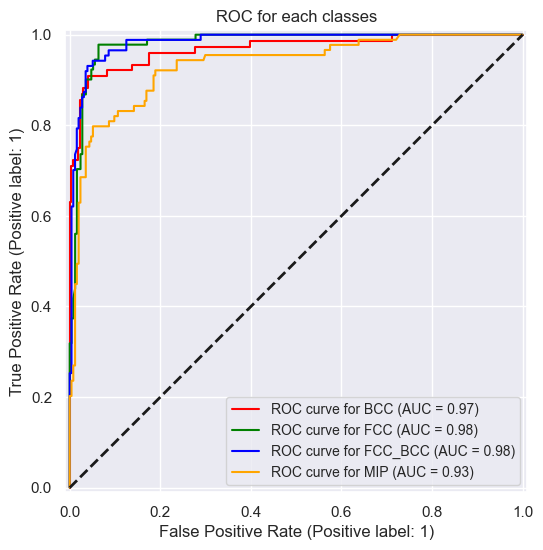

In [18]:
# PLOT ROC CURVE
fig, ax = plt.subplots(figsize=(6, 6))
y_test_oh = to_categorical(y_test)
colors = cycle(["red", "green", "blue", "orange"])
for class_id, color in zip(range(4), colors):
    RocCurveDisplay.from_predictions(
        y_test_oh[:, class_id],
        pred_proba[:, class_id],
        name=f"ROC curve for {labels[class_id]}",
        color=color,
        ax=ax,
    )
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.legend(loc='lower right', fontsize='10')
plt.title("ROC for each classes")
plt.savefig(pwd+"/figures/gb_roc_curve.png", dpi=600, bbox_inches="tight")

Training accuracy per class: [0.98579545 0.98813056 0.98533724 0.93510324]
Testing accuracy per class: [0.89473684 0.86813187 0.94252874 0.80898876]


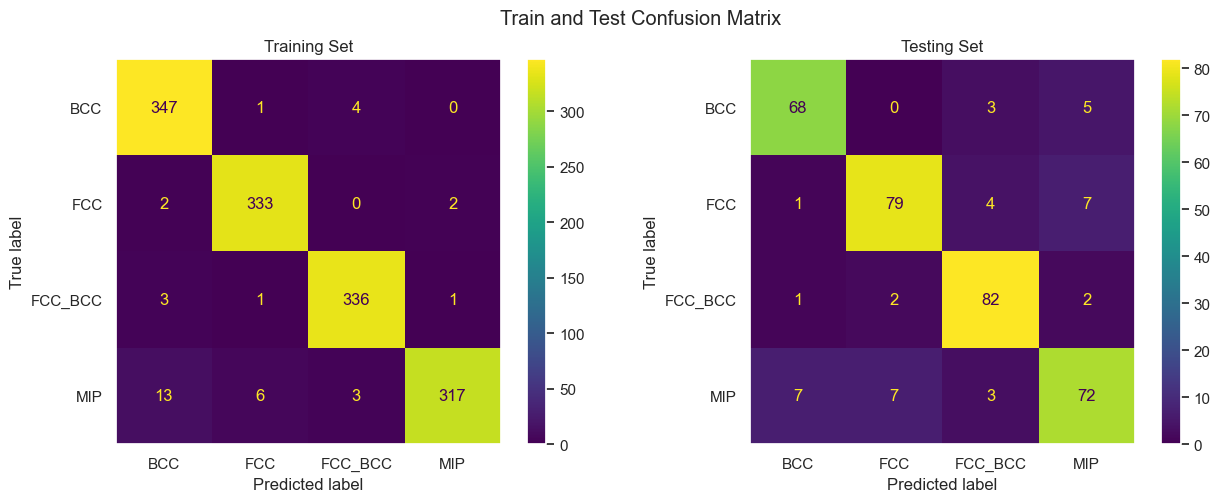

In [19]:
# CONFUSION MATRIX
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)
f,(ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)
disp_train.plot(ax = ax1)
disp_test.plot(ax = ax2)
ax1.set_title('Training Set')
ax2.set_title('Testing Set')
ax1.grid(False)
ax2.grid(False)
plt.suptitle('Train and Test Confusion Matrix')
plt.savefig(pwd+"/figures/gb_cf.png", dpi=600, bbox_inches="tight")
# ACCURACY PER CLASS
acc_class_train = cm_train.diagonal() / cm_train.sum(axis=1)
acc_class_test = cm_test.diagonal() / cm_test.sum(axis=1)

print("Training accuracy per class:", acc_class_train)
print("Testing accuracy per class:", acc_class_test)

In [20]:
# 10 FOLD CROSS VALIDATION
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = []

for train_idx, test_idx in kfold.split(X, y):
    X_train_cv, y_train_cv = X.iloc[train_idx], y[train_idx]
    X_test_cv, y_test_cv = X.iloc[test_idx], y[test_idx]
    best_model.fit(X_train_cv, y_train_cv)
    y_test_pred_cv = best_model.predict(X_test_cv)
    score = accuracy_score(y_test_cv, y_test_pred_cv)
    cv_scores.append(score*100)

print("Cross Validation Score")
print("-"*50)
print(f"Mean Accuracy: {np.mean(cv_scores): .4f} % \nStandard Deviation: (+/-){np.std(cv_scores): .4f} %")
print("-"*50)

Cross Validation Score
--------------------------------------------------
Mean Accuracy:  87.2066 % 
Standard Deviation: (+/-) 2.3496 %
--------------------------------------------------
